# Contextual bandit

What is the optimal policy for a one-dimensional contextual bandit environment with a bimodal reward-state distribution?

## Define environment

# Hyperparameters: constant

- Standard deviation of normal distributions $\sigma$
- Relative weightings of the two distributions in the mix $p$

### Hyperparameters: variable

- Midpoint between the means of the normal distributions
- Separation between the means of the normal distributions

### Parameters

- Environmental state (feature / context / cue) $s$ (see [Hyperparameters: variable](#hyperparameters-variable))
- Action choice $a$ 
- Probability of a reward $P(r|s,a)$
- Actual reward in a given instance $R(s,a)$

### Implications of single-timestep episodes

- There's no model of the environment because there are no state transitions (and episode initialisations are random)
- Could be considered a *nonstationary* problem because the expected rewards are changing each episode (even though the hyperdistribution from which those expected rewards are sampled is fixed)

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Normal, Bernoulli
from tqdm.notebook import tqdm

# import jax.numpy as jnp
import matplotlib.pyplot as plt
# from jax.scipy.stats import norm
# import jax.random
# from jax.nn import softmax, sigmoid

# from jax import grad, value_and_grad, vmap
# from flax import linen as nn
# import optax

In [10]:
class BimodalBandit:
    def __init__(self, midpoint, distance, seed, sigma=1, p=0.5):
        self.midpoint = midpoint
        self.distance = distance
        self.p = p
        self.sigma = sigma
        self.mu1 = midpoint - distance / 2
        self.mu2 = midpoint + distance / 2
        torch.manual_seed(seed)

    def define_reward_probability(self, action):
        # action is now expected to be a Tensor directly
        reward_probability = self.p * Normal(self.mu1, self.sigma).log_prob(action).exp() + \
                             (1 - self.p) * Normal(self.mu2, self.sigma).log_prob(action).exp()
        return reward_probability

    def simulate_reward(self, action):
        reward_probability = self.define_reward_probability(action)
        reward = Bernoulli(reward_probability).sample().int()
        return reward

# Ensure action_space is a tensor; this is already the case
action_space = torch.linspace(-10, 10, 4000).view(-1, 1)

# Adjustments for tensor operations
torch.manual_seed(0)
midpoint = 0
distance = 4
bandit = BimodalBandit(midpoint=midpoint, distance=distance, seed=0)

# reward_probabilities = bandit.define_reward_probability(action_space)
# simulated_rewards = torch.tensor([bandit.simulate_reward(action_space[i]).item() for i in range(action_space.size(0))]).float().view(-1, 1)

p_reward_action = torch.tensor([bandit.define_reward_probability(action).item() for action in action_space])
simulated_rewards = torch.tensor([bandit.simulate_reward(action).item() for action in action_space]).float().view(-1, 1)


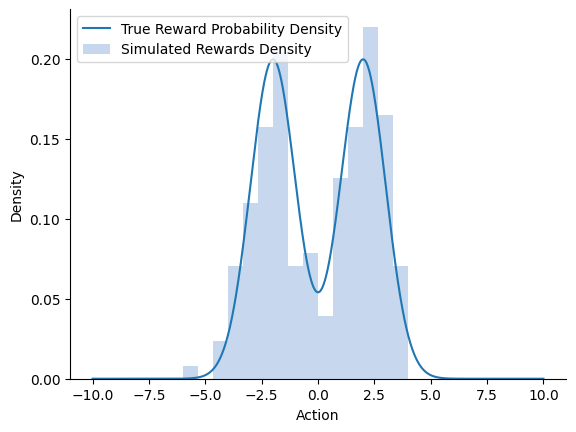

In [3]:
def plot_bimodal_bandit(action_space, p_reward_action, simulated_rewards, phat_reward_action=None, ax=None):
    # If no specific axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    colors = ['#1f77b4', '#aec7e8', '#ff7f0e']  # Extended color palette with an additional color for the estimated rewards

    ax.set_xlabel('Action')
    ax.set_ylabel('Density')

    # Plot the true reward probability density
    ax.plot(action_space.numpy(), p_reward_action.numpy(), color=colors[0], label='True Reward Probability Density')
    
    # Plot the estimated reward probability density only if it's provided
    if phat_reward_action is not None:
        ax.plot(action_space.numpy(), phat_reward_action.numpy(), color=colors[2], linestyle='--', label='Estimated Reward Probability Density')

    # Ensure action_space and simulated_rewards are compatible with histogram plotting
    simulated_rewards_flat = simulated_rewards.flatten()

    # Normalize simulated_rewards for density plot
    simulated_rewards_density = simulated_rewards_flat / simulated_rewards_flat.sum()

    ax.hist(action_space.numpy().flatten(), 
            weights=simulated_rewards_density.numpy(), 
            bins=30, alpha=0.7, 
            color=colors[1], 
            density=True, 
            label='Simulated Rewards Density')

    # Add a legend to the provided axis
    ax.legend()

    # Create L-shaped box on the provided axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot only if we're not plotting on an existing axis
    if ax is None:
        plt.show()

plot_bimodal_bandit(action_space, p_reward_action, simulated_rewards)

### Key steps
1. **Sample** trajectories
2. **Fit** a model (e.g. environment / value function)
3. **Improve** the policy

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Define different neural network structures

class SmallNN(nn.Module):
    def __init__(self):
        super(SmallNN, self).__init__()
        self.fc1 = nn.Linear(1, 32)  # Smaller network
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.1)  # Less dropout

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class MediumNN(nn.Module):
    def __init__(self):
        super(MediumNN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class LargeNN(nn.Module):
    def __init__(self):
        super(LargeNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)  # Larger network
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(p=0.3)  # More dropout

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


In [24]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Training function, using fixed lambda_reg_l1 and lambda_reg_l2 values
def train_model(model, optimizer, actions, rewards, epochs=500, lambda_reg_l1=0.0001, lambda_reg_l2=0.001):
    losses = []
    for epoch in tqdm(range(epochs), desc=f"Training Progress - {model.__class__.__name__}"):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()
        logits = model(actions)
        loss = F.binary_cross_entropy_with_logits(logits, rewards, reduction='mean')
        l1_penalty = sum(torch.abs(param).sum() for param in model.parameters())
        l2_penalty = sum(torch.square(param).sum() for param in model.parameters())
        total_loss = loss + lambda_reg_l1 * l1_penalty + lambda_reg_l2 * l2_penalty
        total_loss.backward()
        optimizer.step()
        losses.append(total_loss.item())
    
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item()}")
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        logits = model(actions)
        probabilities = torch.sigmoid(logits)

    return probabilities, losses


In [49]:
def get_model(model_type):
    model_classes = {
        'SmallNN': SmallNN,
        'MediumNN': MediumNN,
        'LargeNN': LargeNN
    }
    model_class = model_classes.get(model_type)
    if model_class:
        return model_class()
    else:
        raise ValueError(f"Unknown model type: {model_type}")

losses_dict = {}
model_configs = ['SmallNN', 'MediumNN', 'LargeNN']
epochs = 1000
results = {}

for model_type in model_configs:
    print(f"Training {model_type}")
    model = get_model(model_type)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # action_space and simulated_rewards need to be defined beforehand
    probabilities, losses = train_model(model, optimizer, action_space, simulated_rewards, epochs=epochs)
    model_weights = {name: param.clone().detach() for name, param in model.named_parameters()}
    results[model_type] = {'probabilities': probabilities, 'losses': losses, 'weights': model_weights}


Training SmallNN


Training Progress - SmallNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.5962791442871094
Epoch 100, Loss: 0.17610567808151245
Epoch 200, Loss: 0.16975505650043488
Epoch 300, Loss: 0.16723452508449554
Epoch 400, Loss: 0.16626739501953125
Epoch 500, Loss: 0.1655462086200714
Epoch 600, Loss: 0.16389428079128265
Epoch 700, Loss: 0.1654588133096695
Epoch 800, Loss: 0.163208469748497
Epoch 900, Loss: 0.16260205209255219
Training MediumNN


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.8979661464691162
Epoch 100, Loss: 0.18479950726032257
Epoch 200, Loss: 0.17222252488136292
Epoch 300, Loss: 0.1678154021501541
Epoch 400, Loss: 0.16605591773986816
Epoch 500, Loss: 0.1661757081747055
Epoch 600, Loss: 0.1654803305864334
Epoch 700, Loss: 0.16570769250392914
Epoch 800, Loss: 0.16600756347179413
Epoch 900, Loss: 0.16514550149440765
Training LargeNN


Training Progress - LargeNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.9310253858566284
Epoch 100, Loss: 0.1922382116317749
Epoch 200, Loss: 0.17436334490776062
Epoch 300, Loss: 0.17433205246925354
Epoch 400, Loss: 0.1729866862297058
Epoch 500, Loss: 0.17412474751472473
Epoch 600, Loss: 0.17341388761997223
Epoch 700, Loss: 0.17091624438762665
Epoch 800, Loss: 0.17105072736740112
Epoch 900, Loss: 0.17114228010177612


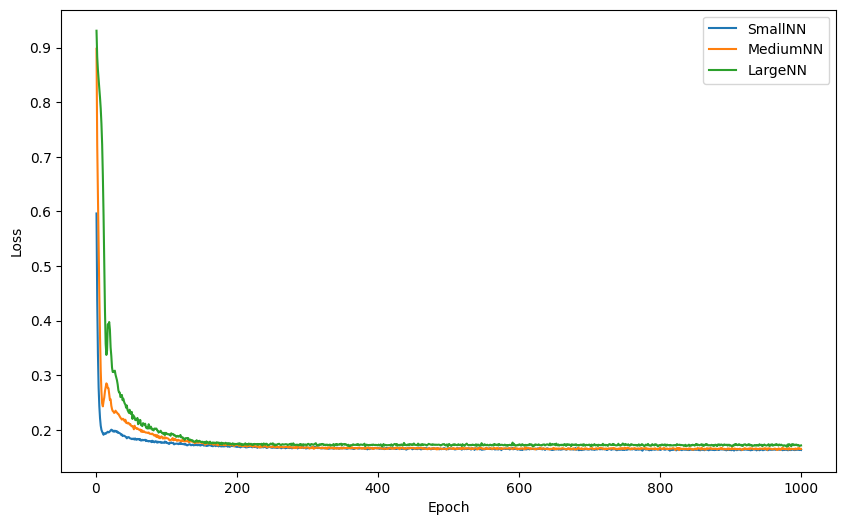

In [50]:
def plot_training_losses(results):
    plt.figure(figsize=(10, 6))
    
    for model_type, data in results.items():
        losses = data['losses']
        epochs = range(1, len(losses) + 1)
        plt.plot(epochs, losses, label=model_type)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_losses(results)


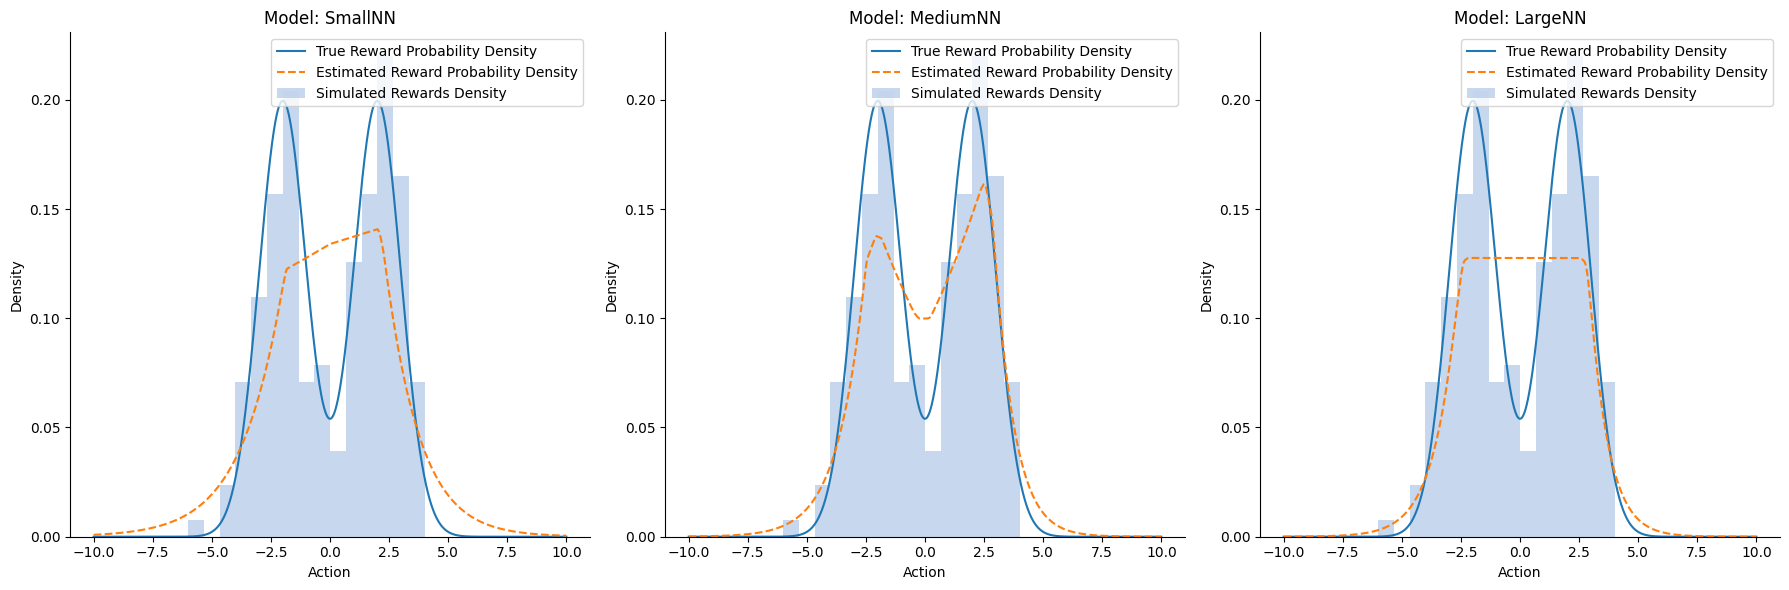

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed

# Iterate over models and their respective axes
for ax, (model_type, model_data) in zip(axs, results.items()):
    # Use the original plot_bimodal_bandit function for each subplot
    plot_bimodal_bandit(action_space, p_reward_action, simulated_rewards, phat_reward_action=model_data['probabilities'], ax=ax)
    ax.set_title(f"Model: {model_type}")

plt.tight_layout()
plt.show()


In [53]:
# Parameters to iterate over
lambda_reg_l1_values = [0.0, 0.0001, 0.001]
lambda_reg_l2_values = [0.0, 0.0001, 0.001]
epochs = 1000
results = {}

for l1 in lambda_reg_l1_values:
    for l2 in lambda_reg_l2_values:
        print(f"Training with L1: {l1}, L2: {l2}")
        model = MediumNN()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        probabilities, losses = train_model(model, optimizer, action_space, simulated_rewards, epochs=epochs, lambda_reg_l1=l1, lambda_reg_l2=l2)
        model_weights = {name: param.clone().detach() for name, param in model.named_parameters()}
        results[(l1, l2)] = {'probabilities': probabilities, 'losses': losses, 'weights': model_weights}


Training with L1: 0.0, L2: 0.0


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.738828182220459
Epoch 100, Loss: 0.15727613866329193
Epoch 200, Loss: 0.14935635030269623
Epoch 300, Loss: 0.14675718545913696
Epoch 400, Loss: 0.1473531424999237
Epoch 500, Loss: 0.14482492208480835
Epoch 600, Loss: 0.14596696197986603
Epoch 700, Loss: 0.14558561146259308
Epoch 800, Loss: 0.14364387094974518
Epoch 900, Loss: 0.14447902143001556
Training with L1: 0.0, L2: 0.0001


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.5407702326774597
Epoch 100, Loss: 0.15819625556468964
Epoch 200, Loss: 0.15299810469150543
Epoch 300, Loss: 0.15027783811092377
Epoch 400, Loss: 0.1497770994901657
Epoch 500, Loss: 0.14828899502754211
Epoch 600, Loss: 0.14725641906261444
Epoch 700, Loss: 0.14701500535011292
Epoch 800, Loss: 0.14634719491004944
Epoch 900, Loss: 0.14653144776821136
Training with L1: 0.0, L2: 0.001


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.9516006112098694
Epoch 100, Loss: 0.17623496055603027
Epoch 200, Loss: 0.1631656140089035
Epoch 300, Loss: 0.159499853849411
Epoch 400, Loss: 0.16105057299137115
Epoch 500, Loss: 0.16040374338626862
Epoch 600, Loss: 0.16043002903461456
Epoch 700, Loss: 0.15961511433124542
Epoch 800, Loss: 0.16050757467746735
Epoch 900, Loss: 0.16090373694896698
Training with L1: 0.0001, L2: 0.0


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.7497888803482056
Epoch 100, Loss: 0.16961918771266937
Epoch 200, Loss: 0.16302959620952606
Epoch 300, Loss: 0.158992737531662
Epoch 400, Loss: 0.15483291447162628
Epoch 500, Loss: 0.1537843644618988
Epoch 600, Loss: 0.15277491509914398
Epoch 700, Loss: 0.1507226973772049
Epoch 800, Loss: 0.15066592395305634
Epoch 900, Loss: 0.14988231658935547
Training with L1: 0.0001, L2: 0.0001


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.8035063743591309
Epoch 100, Loss: 0.17442692816257477
Epoch 200, Loss: 0.16412848234176636
Epoch 300, Loss: 0.158009335398674
Epoch 400, Loss: 0.1548222005367279
Epoch 500, Loss: 0.15551228821277618
Epoch 600, Loss: 0.15391911566257477
Epoch 700, Loss: 0.15401554107666016
Epoch 800, Loss: 0.1528899073600769
Epoch 900, Loss: 0.15293745696544647
Training with L1: 0.0001, L2: 0.001


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.93740314245224
Epoch 100, Loss: 0.18733656406402588
Epoch 200, Loss: 0.17500364780426025
Epoch 300, Loss: 0.16950251162052155
Epoch 400, Loss: 0.1664661169052124
Epoch 500, Loss: 0.16513513028621674
Epoch 600, Loss: 0.16533327102661133
Epoch 700, Loss: 0.16694651544094086
Epoch 800, Loss: 0.16485723853111267
Epoch 900, Loss: 0.16462795436382294
Training with L1: 0.001, L2: 0.0


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.8926327228546143
Epoch 100, Loss: 0.21419702470302582
Epoch 200, Loss: 0.19615453481674194
Epoch 300, Loss: 0.19103337824344635
Epoch 400, Loss: 0.1878274381160736
Epoch 500, Loss: 0.18245533108711243
Epoch 600, Loss: 0.17975936830043793
Epoch 700, Loss: 0.1775791049003601
Epoch 800, Loss: 0.17774949967861176
Epoch 900, Loss: 0.18005500733852386
Training with L1: 0.001, L2: 0.0001


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 1.144120693206787
Epoch 100, Loss: 0.22291412949562073
Epoch 200, Loss: 0.19806444644927979
Epoch 300, Loss: 0.19236335158348083
Epoch 400, Loss: 0.1861123889684677
Epoch 500, Loss: 0.1848311573266983
Epoch 600, Loss: 0.1816815286874771
Epoch 700, Loss: 0.17958366870880127
Epoch 800, Loss: 0.1808282434940338
Epoch 900, Loss: 0.17947863042354584
Training with L1: 0.001, L2: 0.001


Training Progress - MediumNN:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.9567667841911316
Epoch 100, Loss: 0.21117639541625977
Epoch 200, Loss: 0.1980016678571701
Epoch 300, Loss: 0.19048690795898438
Epoch 400, Loss: 0.1860641986131668
Epoch 500, Loss: 0.18317848443984985
Epoch 600, Loss: 0.18417590856552124
Epoch 700, Loss: 0.18462999165058136
Epoch 800, Loss: 0.1832909882068634
Epoch 900, Loss: 0.1835697889328003


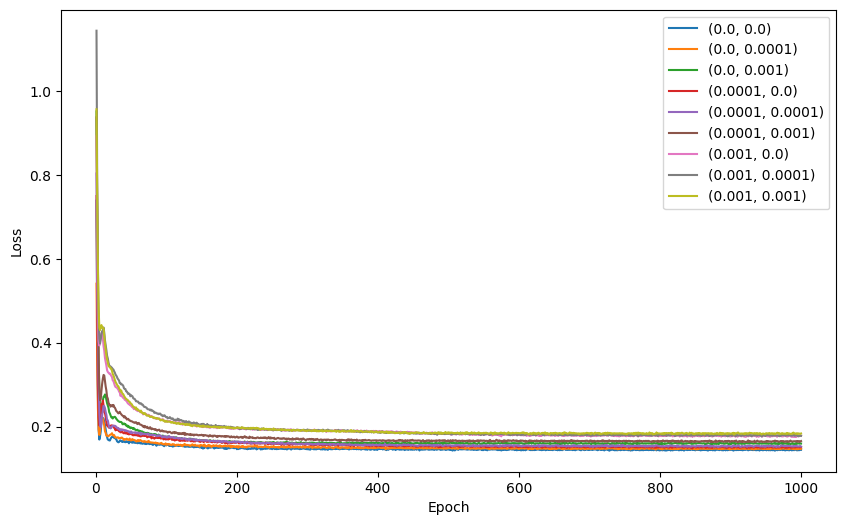

In [54]:
plot_training_losses(results)


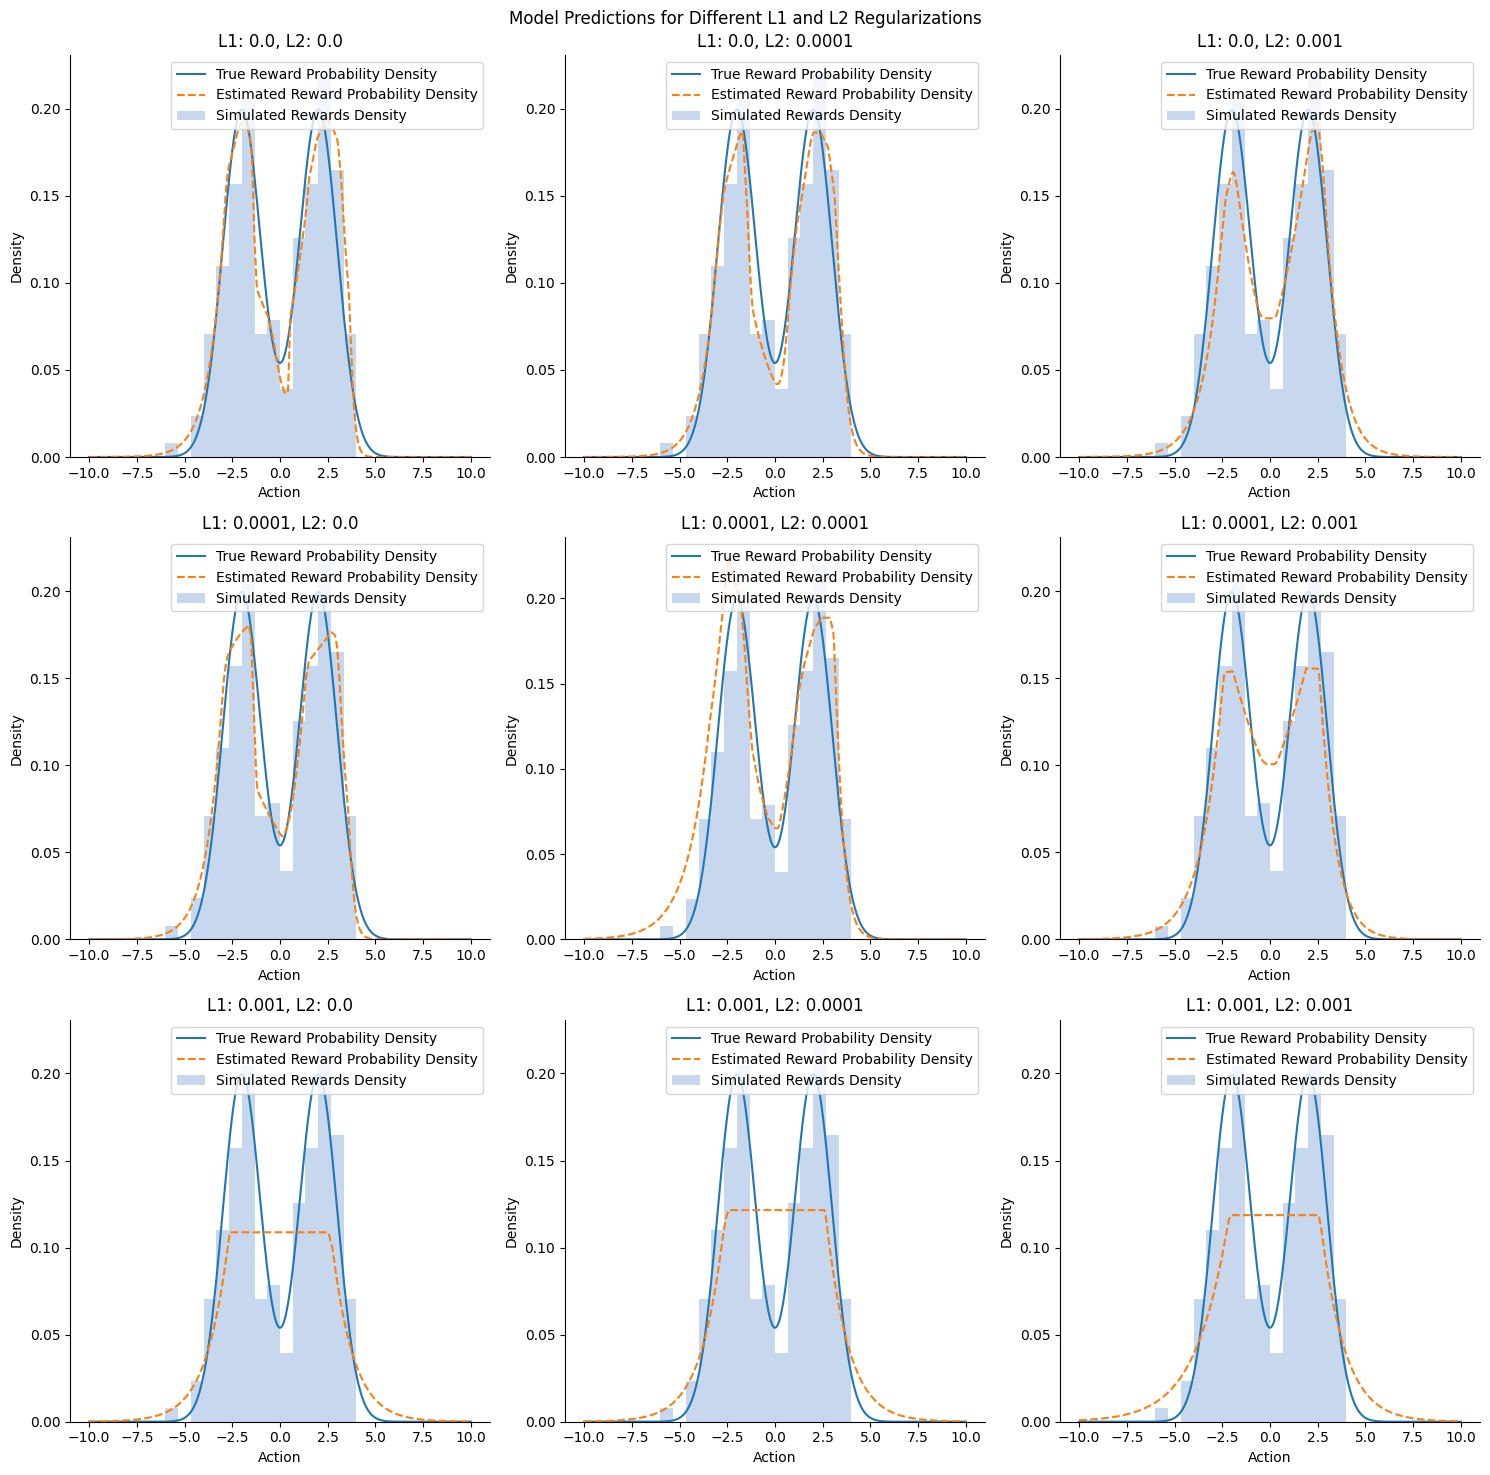

In [55]:
# Number of rows and columns for the subplot grid
num_rows = len(lambda_reg_l1_values)
num_columns = len(lambda_reg_l2_values)

# Create a figure for the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows))
fig.suptitle('Model Predictions for Different L1 and L2 Regularizations')

# Check if we have a single row/column to avoid indexing issues
if num_rows == 1 or num_columns == 1:
    axes = np.array(axes).reshape(num_rows, -1)

# Loop through all combinations of L1 and L2 values
for i, l1 in enumerate(lambda_reg_l1_values):
    for j, l2 in enumerate(lambda_reg_l2_values):
        ax = axes[i, j] if num_rows > 1 and num_columns > 1 else axes[max(i, j)]
        # Adjusting how probabilities are accessed based on the new results format
        probabilities = results[(l1, l2)]['probabilities']
        
        plot_bimodal_bandit(action_space, p_reward_action, simulated_rewards, phat_reward_action=probabilities, ax=ax) 
        ax.set_title(f'L1: {l1}, L2: {l2}')

# Adjust layout so titles and labels don't overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top spacing to accommodate the main title
plt.show()


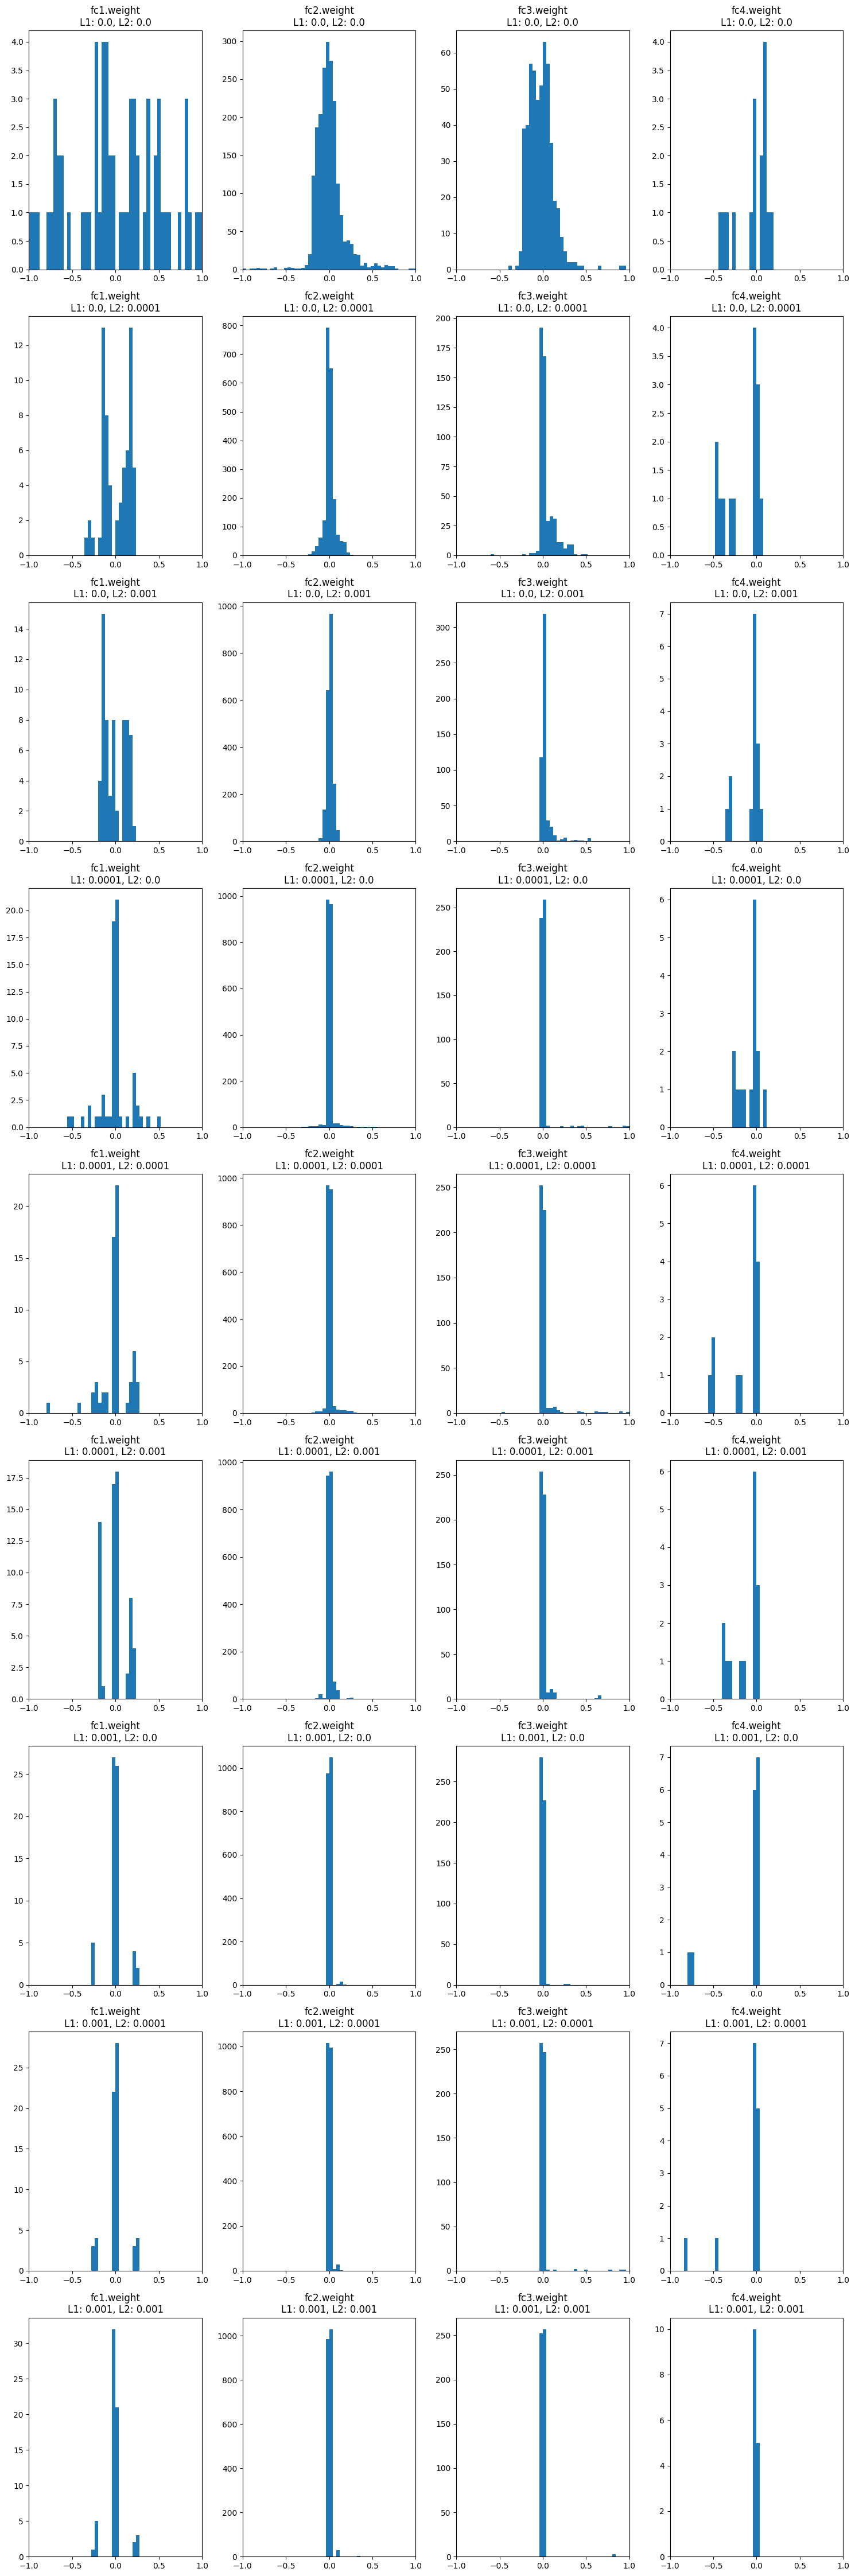

In [56]:
def plot_all_weight_distributions(results, x_min=-1, x_max=1):
    # Determine the number of subplot rows needed (one row per combination)
    num_combinations = len(results.keys())
    
    # Creating a large figure to hold all subplots
    fig_size_width = 15
    fig_size_height = 5 * num_combinations
    plt.figure(figsize=(fig_size_width, fig_size_height))
    
    # Counter for the current subplot position
    subplot_counter = 1
    
    for (l1, l2), data in results.items():
        weights = data['weights']
        num_layers = sum(1 for name in weights if "weight" in name)
        
        for name, weight in weights.items():
            if "weight" in name:  # Filter out biases and other parameters if present
                weight_data = weight.data.numpy().flatten()
                
                # Create a subplot for each layer's weight distribution
                plt.subplot(num_combinations, num_layers, subplot_counter)
                plt.hist(weight_data, bins=50, range=(x_min, x_max))  # Set custom x-axis limits
                plt.xlim(x_min, x_max)  # Ensure x-axis limits are applied
                plt.title(f'{name}\nL1: {l1}, L2: {l2}')
                
                subplot_counter += 1

    plt.tight_layout()
    plt.show()

# Call the function with your results dictionary and custom x-axis limits
plot_all_weight_distributions(results, x_min=-1, x_max=1)


## TODO

### Define policy
- Inputs: state $s$
- Outputs: action $a$

### Generate reward samples 
- Generate action according to the policy
- Sample rewards from those action

### Estimate value of action
- Since each episode is one timestep, total return = reward at $t{0}$

### Update the policy 
- RL: gradient descent (batch size = full sample)
- EA: geometric mean?
- Minimax: regret

How should the EA and minimax updates be calculated?

### Action effects on environment (full MDP)
- Transition (environmental feedback) dynamics $P(s'|a,s)$
- Discount rate $\gamma$